In [1]:
import os
import rdkit
import torch.optim as optim
import dgl
import numpy as np
import pandas as pd
import torch
import pubchempy
import re
import sys
import torch.nn.functional as F
import math
import pickle
import gc
import time
import psutil
import tracemalloc
import ast
import dill
import copy
import torch.nn.init as init
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from joblib import Parallel, delayed
from multiprocessing import pool
from tqdm import tqdm
from math import sqrt
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit.Chem import Draw, AllChem
from dgl.nn.pytorch.glob import AvgPooling
from dgllife.model import load_pretrained
from dgllife.model.pretrain.moleculenet import *
from dgllife.model.pretrain.generative_models import *
from dgllife.model.pretrain.property_prediction import *
from dgllife.model.pretrain.reaction import *
from dgllife.utils import mol_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch import nn
from rdkit import Chem
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc, mean_absolute_error,mean_squared_error
from torch.autograd import Variable

In [2]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


class Mydataset(torch.utils.data.Dataset):
    def __init__(self, drug, adrname, macc, morgan, rtoplo, pharm,   contextpred, edgepred, infomax, masking, macc_similar, morgan_similar, rtoplo_similar, pharm_similar, contextpred_simila, edgepred_similar, infomax_similar, masking_similar, adr, adr1, adr2 , _y, _y1):
        self.drug = drug
        self.adrname = adrname
        self.data_adr = adr
        self.data_adr1 = adr1
        self.data_adr2 = adr2
        self.data_y = _y
        self.data_y1 = _y1
        #FP
        self.data_macc = macc
        self.data_morgan = morgan
        self.data_rtoplo = rtoplo
        self.data_pharm = pharm
        #molecule
        self.data_contextpred = contextpred
        self.data_edgepred = edgepred
        self.data_infomax = infomax
        self.data_masking = masking
        #similar
        self.data_macc_similar = macc_similar
        self.data_morgan_similar = morgan_similar
        self.data_rtoplo_similar = rtoplo_similar
        self.data_pharm_similar = pharm_similar
        self.data_contextpred_similar = contextpred_simila
        self.data_edgepred_similar = edgepred_similar
        self.data_infomax_similar = infomax_similar
        self.data_masking_similar = masking_similar
        

    def __getitem__(self, index):
        drug = self.drug[index]
        adr  = self.adrname[index]
        adr_1 = self.data_adr[index]
        adr1_1 = self.data_adr1[index]
        adr1_2 = self.data_adr2[index]
        label_1 = self.data_y[index]
        label_2 = self.data_y1[index]
        
        macc_1 = self.data_macc[index]
        morgan_1 = self.data_morgan[index]
        rtoplo_1 = self.data_rtoplo[index]
        pharm_1 = self.data_pharm[index]
        
        contextpred_1 = self.data_contextpred[index]
        edgepred_1 = self.data_edgepred[index]
        infomax_1 = self.data_infomax[index]
        masking_1 = self.data_masking[index]
        
        similar_macc_1 = self.data_macc_similar[index]
        similar_morgan_1 = self.data_morgan_similar[index]
        similar_rtoplo_1 = self.data_rtoplo_similar[index]
        similar_pharm_1 = self.data_pharm_similar[index]
        similar_contextpred_1 = self.data_contextpred_similar[index]
        similar_edgepred_1 = self.data_edgepred_similar[index]
        similar_infomax_1 = self.data_infomax_similar[index]
        similar_masking_1 = self.data_masking_similar[index]

        return drug, adr, macc_1, morgan_1, rtoplo_1, pharm_1, contextpred_1, edgepred_1, infomax_1, masking_1, similar_macc_1, similar_morgan_1, similar_rtoplo_1, similar_pharm_1, similar_contextpred_1, similar_edgepred_1, similar_infomax_1, similar_masking_1, adr_1, adr1_1, adr1_2, label_1, label_2

    def __len__(self):
        # 返回整个数据集的大小
        return len(self.data_y)

class ScaledDotProductionAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductionAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v] 全文两处用到注意力，一处是self attention，另一处是co attention，前者不必说，后者的k和v都是encoder的输出，所以k和v的形状总是相同的
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        # 1) 计算注意力分数QK^T/sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k)  # scores: [batch_size, n_heads, len_q, len_k]
        # 2)  进行 mask 和 softmax
        # scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)  # attn: [batch_size, n_heads, len_q, len_k]
        # 3) 乘V得到最终的加权和
        context = torch.matmul(attn, V)  # context: [batch_size, n_heads, len_q, d_v]
        '''
        得出的context是每个维度(d_1-d_v)都考虑了在当前维度(这一列)当前token对所有token的注意力后更新的新的值，
        换言之每个维度d是相互独立的，每个维度考虑自己的所有token的注意力，所以可以理解成1列扩展到多列

        返回的context: [batch_size, n_heads, len_q, d_v]本质上还是batch_size个句子，
        只不过每个句子中词向量维度512被分成了8个部分，分别由8个头各自看一部分，每个头算的是整个句子(一列)的512/8=64个维度，最后按列拼接起来
        '''
        return context # context: [batch_size, n_heads, len_q, d_v]
    
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model, n_heads, d_k, d_v, device): #128 2 64 64
        super(MultiHeadAttention, self).__init__()
        self.device = device
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_k
        self.d_v = d_v

    def forward(self, input_Q, input_K, input_V): #bath_size, 9, 64
        '''
        input_Q: [batch_size, len_q, d_model] len_q是作为query的句子的长度，比如enc_inputs（2,5,512）作为输入，那句子长度5就是len_q
        input_K: [batch_size, len_k, d_model]
        input_K: [batch_size, len_v(len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)

        # 1）linear projection [batch_size, seq_len, d_model] ->  [batch_size, n_heads, seq_len, d_k/d_v]
        Q = self.W_Q(input_Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2) # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2) # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2) # V: [batch_size, n_heads, len_v(=len_k), d_v]

        # 2）计算注意力
        # # 自我复制n_heads次，为每个头准备一份mask
        # attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)  # attn_mask: [batch_size, n_heads, seq_len, seq_len]
        context = ScaledDotProductionAttention(self.d_k)(Q, K, V) # context: [batch_size, n_heads, len_q, d_v]

        # 3）concat部分
        context = torch.cat([context[:,i,:,:] for i in range(context.size(1))], dim=-1)
        output = self.concat(context)  # [batch_size, len_q, d_model]
        return nn.LayerNorm(self.d_model).to(self.device)(output + residual)  # output: [batch_size, len_q, d_model]
        '''        
        最后的concat部分，网上的大部分实现都采用的是下面这种方式（也是哈佛NLP团队的写法）
        context = context.transpose(1, 2).reshape(batch_size, -1, d_model)
        output = self.linear(context)
        但是我认为这种方式拼回去会使原来的位置乱序，于是并未采用这种写法，两种写法最终的实验结果是相近的
        '''

class Residual(nn.Module):  # @save
	def __init__(self, input_channels, num_channels,
	             use_1x1conv=False, strides=1):
		super().__init__()
		self.conv1 = nn.Conv2d(input_channels, num_channels,
		                       kernel_size=3, padding=1, stride=strides)
		self.conv2 = nn.Conv2d(num_channels, num_channels,
		                       kernel_size=3, padding=1)
		if use_1x1conv:
			self.conv3 = nn.Conv2d(input_channels, num_channels,
			                       kernel_size=1, stride=strides)
		else:
			self.conv3 = None
		self.bn1 = nn.BatchNorm2d(num_channels)
		self.bn2 = nn.BatchNorm2d(num_channels)

	def forward(self, X):  # batch*1*167
		Y = F.relu(self.bn1(self.conv1(X)))
		Y = self.bn2(self.conv2(Y))
		if self.conv3:
			X = self.conv3(X)
		Y += X
		return F.relu(Y)


def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
	blk = []
	for i in range(num_residuals):
		if i == 0 and not first_block:
			blk.append(Residual(input_channels, num_channels,
			                    use_1x1conv=True, strides=2))
		else:
			blk.append(Residual(num_channels, num_channels))
	return blk

class map_layer(nn.Module):
    def __init__(self, hide: list=['infeature', 128, 32, 1], activate=nn.ReLU(),  normal=True):#hide:[]
        super(map_layer, self).__init__()
        self.map_layer = nn.ModuleList()
        for i, j in zip(hide, hide[1:]):
            self.map_layer.append(nn.Linear(i, j))
            if normal:
                self.map_layer.append(nn.BatchNorm1d(j))
            self.map_layer.append(activate)

    def forward(self, x):
        for layer in self.map_layer:
            x = layer(x)
        return x

class MLP(nn.Module):
    def __init__(self, hide: list=['infeature', 128, 32, 1], activate=nn.ReLU(), drop=0.5, normal=True):#hide:[]
        super(MLP, self).__init__()
        self.combine_layerf = nn.ModuleList()
        for i, j in zip(hide, hide[1:]):
            self.combine_layerf.append(nn.Linear(i, j))
            if j != 1:
                if normal:
                    self.combine_layerf.append(nn.BatchNorm1d(j))
                self.combine_layerf.append(activate)
                self.combine_layerf.append(nn.Dropout(drop))

    def forward(self, x):
        for layer in self.combine_layerf:
            x = layer(x)
        return x
    
class MultiFG(nn.Module):
    def __init__(self, feature_size, output_size, similar_feature_size, device, out_layer:str="KAN", full_layerb:list = ['feature_size'*10, 256, 64, 1], full_layerf: list=['feature_size'*10, 256, 64, 1], activation=nn.ReLU()):
        super(MultiFG, self).__init__()
        self.out_layer = out_layer
        self.device=device
        self.output_size = output_size
        self.feature_size = feature_size
        #macc指纹的映射层
        self.share_size = [feature_size]
        self.map_macc = map_layer([167]+self.share_size, activate=activation, normal=True)

        #pubchem指纹的映射层
        self.map_pubchem = map_layer([881]+self.share_size, activate=activation, normal=True)
        
        #morgan指纹的映射层
        self.map_morgan = map_layer([2048]+self.share_size, activate=activation, normal=True)

        #Rtoplo指纹的映射层
        self.map_Rtoplo = map_layer([2048]+self.share_size, activate=activation, normal=True)
        
        #pubchem指纹的映射层
        self.map_pharm = map_layer([441]+self.share_size, activate=activation, normal=True)


        #molecule的映射层
        self.map_molecule = map_layer([300]+self.share_size, activate=activation)
        
        #adr的映射层,是基于相似的特征，所以这里的输入尺度应该是指训练集所有adr的维度
        self.map_adr = map_layer([similar_feature_size[8]]+self.share_size, activate=activation)
        self.map_adr_12 = map_layer([similar_feature_size[9]]+self.share_size, activate=activation)
 
        
        #相似的映射层，训练集所有药物数量维度
        self.map_similar_macc = map_layer([similar_feature_size[0]]+self.share_size,  activate=activation)
        self.map_similar_morgan = map_layer([similar_feature_size[1]]+self.share_size,  activate=activation)
        self.map_similar_rtoplo = map_layer([similar_feature_size[2]]+self.share_size,  activate=activation)
        self.map_similar_pharm = map_layer([similar_feature_size[3]]+self.share_size,  activate=activation)
        self.map_similar_context = map_layer([similar_feature_size[4]]+self.share_size,  activate=activation)
        self.map_similar_edge = map_layer([similar_feature_size[5]]+self.share_size,  activate=activation)
        self.map_similar_infomax = map_layer([similar_feature_size[6]]+self.share_size,  activate=activation)
        self.map_similar_masking = map_layer([similar_feature_size[7]]+self.share_size,  activate=activation)
        
        #一个高维卷积+两个残差块
        self.residual_cov = nn.Sequential(
            nn.Conv2d(2,2,7,1,3),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            *resnet_block(2, 8, 1, first_block=False),
            *resnet_block(8, 16, 1),
            *resnet_block(16,32,1),
            nn.AvgPool2d(3,1,1)
        )

        self.fusion_layer = MultiHeadAttention(feature_size, 2, int(feature_size/2), int(feature_size/2), self.device)
        
        # 预测层
        self.com_layerf = KAN(full_layerf)
        self.com_layerb = MLP(full_layerb, activation)

    def forward(self, macc, morgan, Rtoplo, pharm, contextpred, edgepred, infomax, masking, macc_similar, morgan_similar, rtoplo_similar, pharm_similar, contextpred_similar, edgepred_similar, infomax_similar, masking_similar, adr_feature, adr_feature1, adr_feature2): #macc batch*167
        '''
        param
            fplist：指纹特征列表
            molecule：分子图嵌入特征
            adrfeature：adr相似特征
            hid1：映射的特征空间的维度
        '''
        #map FP
        macc_1 = self.map_macc(macc)
        morgan_1 = self.map_morgan(morgan)
        Rtoplo_1 = self.map_Rtoplo(Rtoplo)
        pharm_1 = self.map_pharm(pharm)
        # rtoplo_1 = self.create_hiddle(rtoplo.size()[1])(rtoplo)
        #map molecule
        contextpred_1, edgepred_1, infomax_1, masking_1 = self.map_molecule(contextpred), self.map_molecule(edgepred), self.map_molecule(infomax), self.map_molecule(masking)
        
        #map similar
        macc_similar_1, morgan_similar_1, rtoplo_similar_1, pharm_similar_1, contextpred_simila_1, edgepred_similar_1, infomax_similar_1, masking_similar_1 = self.map_similar_macc(macc_similar), self.map_similar_morgan(morgan_similar), self.map_similar_rtoplo(rtoplo_similar), self.map_similar_pharm(pharm_similar), self.map_similar_context(contextpred_similar), self.map_similar_edge(edgepred_similar), self.map_similar_infomax(infomax_similar), self.map_similar_masking(masking_similar)

        #map adr_feature
        adr_feature_1 = self.map_adr(adr_feature)
        adr_feature1_1 = self.map_adr_12(adr_feature1)
        adr_feature1_2 = self.map_adr_12(adr_feature2)
        

        #为每个特征增加一个维度
        macc_2, morgan_2, Rtoplo_2, pharm_2, contextpred_2, edgepred_2, infomax_2, masking_2, macc_similar_2, morgan_similar_2, rtoplo_similar_2, pharm_similar_2, contextpred_simila_2, edgepred_similar_2, infomax_similar_2, masking_similar_2 = macc_1.unsqueeze(1), morgan_1.unsqueeze(1), Rtoplo_1.unsqueeze(1), pharm_1.unsqueeze(1), contextpred_1.unsqueeze(1), edgepred_1.unsqueeze(1), infomax_1.unsqueeze(1), masking_1.unsqueeze(1), macc_similar_1.unsqueeze(1), morgan_similar_1.unsqueeze(1), rtoplo_similar_1.unsqueeze(1), pharm_similar_1.unsqueeze(1), contextpred_simila_1.unsqueeze(1), edgepred_similar_1.unsqueeze(1), infomax_similar_1.unsqueeze(1), masking_similar_1.unsqueeze(1)
        adr_feature_2, adr_feature1_3, adr_feature1_4 = adr_feature_1.unsqueeze(1), adr_feature1_1.unsqueeze(1), adr_feature1_2.unsqueeze(1)
        
        
        # feature_stack = torch.cat([macc_2, morgan_2, Rtoplo_2, pharm_2, molecule_2, macc_2_similar, morgan_2_similar, Rtoplo_2_similar, pharm_2_similar], dim=1) #batchsize * 9 * feature_size
        
        #FP堆积
        feature_FP = torch.cat([macc_2, morgan_2, Rtoplo_2, pharm_2], dim=1) #batch_size * 4 *feature_size
        
        #molecule堆积
        feature_mol = torch.cat([contextpred_2, edgepred_2, infomax_2, masking_2], dim=1) #batch_size * 4 * feature
        
        #similar堆积
        feature_sim = torch.cat([macc_similar_2, morgan_similar_2, rtoplo_similar_2, pharm_similar_2, contextpred_simila_2, edgepred_similar_2, infomax_similar_2, masking_similar_2], dim=1) #batch_size * 8 *feature_size
        
        #adr堆积
        feature_adr = torch.cat([adr_feature_2, adr_feature1_3, adr_feature1_4], dim=1) #batch_size * 3 * feature_size
        
          
        #残差块
        feature_re1,feature_re2,feature_re3 = feature_FP.unsqueeze(1), feature_mol.unsqueeze(1),feature_sim.unsqueeze(1)
        #残差块
        feature_re12 = torch.cat([feature_re1, feature_re2], dim=2)
        feature_fusion2 = self.residual_cov(torch.cat((feature_re12, feature_re3), dim=1))
        #batch_size, 2, 8, feature_size --> batch_size, 32, 1, feature_size/8
        cm1 = feature_fusion2.view(feature_fusion2.size(0), -1)
        #尝试一下只利用药物与不良反应特征经过注意力机制计算后的特征


        #利用feature_adr作为q进行注意力机制,获取药物加权后的特征
        #adr --> FP
        feature_drug = torch.cat([feature_FP,feature_mol,feature_sim], dim=1)
        feature_fusion1 = self.fusion_layer(feature_adr, feature_drug, feature_drug ) #bactch_size,  16, feature_size  -->  batch_size, 3, feature_size
        cm2 = feature_fusion1.view(feature_fusion1.size(0), -1) #摊平batch_size*feature*3
        
        adr_cm = feature_adr.view(feature_adr.size(0), -1)
        combined = torch.cat([cm1, cm2, adr_cm], dim=1)

        # combined = torch.cat(scores_list, dim=1)
        # output = self.combine_layer(combined)
        output_f = self.com_layerf(combined)
        output_b = self.com_layerb(combined)

        return output_b, output_f

def precision(actual, predicted, N):
    if isinstance(N, int):
        inter_set = set(actual) & set(predicted[:N])
        return float(len(inter_set))/float(N)
    elif isinstance(N, list):
        return np.array([precision(actual, predicted, n) for n in N])


def recall(actual, predicted, N):
    if isinstance(N, int):
        inter_set = set(actual) & set(predicted[:N])
        return float(len(inter_set))/float(len(set(actual)))
    elif isinstance(N, list):
        return np.array([recall(actual, predicted, n) for n in N])


def nDCG(Tr, topK, num=None):
    if num is None:
        num = len(topK)
    dcg, vec = 0, []
    for i in range(num):
        if topK[i] in Tr:
            dcg += 1/math.log(i+2, 2)
            vec.append(1)
        else:
            vec.append(0)
    vec.sort(reverse=True)
    idcg = sum([vec[i]/math.log(i+2, 2) for i in range(num)])
    if idcg > 0:
        return dcg/idcg
    else:
        return idcg
    
def map_auc(pos_inx, neg_inx, val):
    map = 0.0
    pos_val, neg_val = val[pos_inx], val[neg_inx]
    ii = np.argsort(pos_val)[::-1]
    jj = np.argsort(neg_val)[::-1]
    pos_sort, neg_sort = pos_val[ii], neg_val[jj]
    auc_num = 0.0
    for i,pos in enumerate(pos_sort):
        num = 0.0
        for neg in neg_sort:
            if pos<=neg:
                num+=1
            else:
                auc_num+=1
        map += (i+1)/(i+num+1)
    return map/len(pos_inx), auc_num/(len(pos_inx)*len(neg_inx))

def evaluate(model, device, vail_loader):
    vali_true_f = np.empty((0,1))
    vali_pre_f = np.empty((0,1))

    vali_true_b = np.empty((0,1))
    vali_pre_b = np.empty((0,1))

    drug_all = np.empty((0,1))
    adr_all = np.empty((0,1))
    model.eval()
    for drug, adr, macc_v, morgan_v, rtoplo_v, pharm_v, contextpred_v, edgepred_v, infomax_v, masking_v, similar_macc_v, similar_morgan_v, similar_rtoplo_v, similar_pharm_v, similar_contextpred_v, similar_edgepred_v, similar_infomax_v, similar_masking_v, adr_v, adr1_v, adr2_v, label_v, labe2_v in vail_loader:     
        macc_v, morgan_v, rtoplo_v, pharm_v, contextpred_v, edgepred_v, infomax_v, masking_v, similar_macc_v, similar_morgan_v, similar_rtoplo_v, similar_pharm_v, similar_contextpred_v, similar_edgepred_v, similar_infomax_v, similar_masking_v = macc_v.to(device), morgan_v.to(device), rtoplo_v.to(device), pharm_v.to(device), contextpred_v.to(device), edgepred_v.to(device), infomax_v.to(device), masking_v.to(device), similar_macc_v.to(device), similar_morgan_v.to(device), similar_rtoplo_v.to(device), similar_pharm_v.to(device), similar_contextpred_v.to(device), similar_edgepred_v.to(device), similar_infomax_v.to(device), similar_masking_v.to(device)
        adr_v, adr1_v, adr2_v, label_v, labe2_v = adr_v.to(device), adr1_v.to(device), adr2_v.to(device), label_v.to(device), labe2_v.to(device)

        adr_v = Variable(adr_v, requires_grad=False).float()
        adr1_v = Variable(adr1_v, requires_grad=False).float()
        adr2_v = Variable(adr2_v, requires_grad=False).float()
        label_v = Variable(label_v, requires_grad=False).float()
        labe2_v = Variable(labe2_v, requires_grad=False).float()
        
        macc_v = Variable(macc_v, requires_grad=False).float()
        morgan_v = Variable(morgan_v, requires_grad=False).float()
        rtoplo_v = Variable(rtoplo_v, requires_grad=False).float()
        pharm_v = Variable(pharm_v, requires_grad=False).float()
        
        contextpred_v = Variable(contextpred_v, requires_grad=False).float()
        edgepred_v = Variable(edgepred_v, requires_grad=False).float()
        infomax_v = Variable(infomax_v, requires_grad=False).float()
        masking_v = Variable(masking_v, requires_grad=False).float()
        
        similar_macc_v = Variable(similar_macc_v, requires_grad=False).float()
        similar_morgan_v = Variable(similar_morgan_v, requires_grad=False).float()
        similar_rtoplo_v = Variable(similar_rtoplo_v, requires_grad=False).float()
        similar_pharm_v = Variable(similar_pharm_v, requires_grad = False).float()
        similar_contextpred_v = Variable(similar_contextpred_v, requires_grad=False).float()
        similar_edgepred_v = Variable(similar_edgepred_v, requires_grad=False).float()
        similar_infomax_v = Variable(similar_infomax_v, requires_grad=False).float()
        similar_masking_v = Variable(similar_masking_v, requires_grad = False).float()
        
        
        output_b_vali, output_f_vali = model.forward(macc_v, morgan_v, rtoplo_v, pharm_v, contextpred_v, edgepred_v, infomax_v, masking_v, similar_macc_v, similar_morgan_v, similar_rtoplo_v, similar_pharm_v, similar_contextpred_v, similar_edgepred_v, similar_infomax_v, similar_masking_v, adr_v, adr1_v, adr2_v)

        
        output_b_vali_1 = torch.sigmoid(output_b_vali)
        output_b_vali=output_b_vali_1.cpu().detach().numpy()
        output_f_vali=output_f_vali.cpu().detach().numpy()

        label_v = label_v.cpu().detach().numpy()
        labe2_v = labe2_v.cpu().detach().numpy()
        
        vali_pre_b=np.concatenate((vali_pre_b,output_b_vali),axis=0)
        vali_pre_f=np.concatenate((vali_pre_f,output_f_vali),axis=0)
        
        label_v = label_v.reshape(-1,1)
        labe2_v = labe2_v.reshape(-1,1)
        
        _drug = np.array(drug).reshape(-1,1)
        _adr = np.array(adr).reshape(-1,1)
        
        drug_all = np.concatenate((drug_all, _drug), axis=0)
        adr_all = np.concatenate((adr_all, _adr), axis=0)
        vali_true_b=np.concatenate((vali_true_b,label_v),axis=0)
        vali_true_f=np.concatenate((vali_true_f,labe2_v),axis=0)
        
        del macc_v, morgan_v, rtoplo_v, pharm_v, contextpred_v, edgepred_v, infomax_v, masking_v, similar_macc_v, similar_morgan_v, similar_rtoplo_v, similar_pharm_v, similar_contextpred_v, similar_edgepred_v, similar_infomax_v, similar_masking_v, adr_v, adr1_v, adr2_v, _drug, _adr
        gc.collect()
        
    # loss_binary = loss_1(output_b, label_1)

    # loss_freq = loss_2(output_f[label_1 == 1], label_2[label_1 == 1]) #只计算阳性样本的freq损失


    auc_v = roc_auc_score(vali_true_b, vali_pre_b)

    precision_v, recall_v, _ = precision_recall_curve(vali_true_b, vali_pre_b)

    aupr_v = auc(recall_v, precision_v)

    rmse_v = sqrt(mean_squared_error(vali_pre_f[vali_true_b==1], vali_true_f[vali_true_b==1]))
    mae_v = mean_absolute_error(vali_pre_f[vali_true_b==1], vali_true_f[vali_true_b==1])
    spearman_v = stats.spearmanr(vali_pre_f[vali_true_b==1], vali_true_f[vali_true_b==1])

    print(f"验证集的AUC:{auc_v},AUPR:{aupr_v},RMSE:{rmse_v},MAE:{mae_v},Spearman:{spearman_v}")
    return drug_all, adr_all,vali_true_b, vali_pre_b, vali_true_f, vali_pre_f

In [16]:
pre_fold = []
rec_fold = []
ndcg_fold = []
true_folder = {}
pred_folder = {}
drug_folder = {}
adr_folder = {}
for i in tqdm(range(10)):
    model_dicit = torch.load(f'./result/model/model/dicit_model{i+1}.pth', map_location='cpu')
    with open(f'./result/loader/loader/vail_loader{i+1}.pkl','rb') as f:
                vail_loader = dill.load(f)
    vail_dataset = Mydataset(vail_loader.dataset.drug, vail_loader.dataset.adrname, vail_loader.dataset.data_macc, vail_loader.dataset.data_morgan, vail_loader.dataset.data_rtoplo, vail_loader.dataset.data_pharm, vail_loader.dataset.data_contextpred, vail_loader.dataset.data_edgepred,  vail_loader.dataset.data_infomax, vail_loader.dataset.data_masking, vail_loader.dataset.data_macc_similar, vail_loader.dataset.data_morgan_similar, vail_loader.dataset.data_rtoplo_similar, vail_loader.dataset.data_pharm_similar,  vail_loader.dataset.data_contextpred_similar, vail_loader.dataset.data_edgepred_similar, vail_loader.dataset.data_infomax_similar, vail_loader.dataset.data_masking_similar, vail_loader.dataset.data_adr, vail_loader.dataset.data_adr1, vail_loader.dataset.data_adr2, vail_loader.dataset.data_y, vail_loader.dataset.data_y1)

    vail_loader1 = DataLoader(dataset=vail_dataset,batch_size=512,shuffle=False)
    
    for drug, adr, macc_1, morgan_1, rtoplo_1, pharm_1, contextpred_1, edgepred_1, infomax_1, masking_1, similar_macc_1, similar_morgan_1, similar_rtoplo_1, similar_pharm_1, similar_contextpred_1, similar_edgepred_1, similar_infomax_1, similar_masking_1, adr_1, adr1_1, adr1_2, label_1, label_2 in vail_loader1:
        # print(str(similar_macc_1.shape) + str(similar_morgan_1.shape) + str(similar_rtoplo_1.shape) + str(similar_pharm_1.shape) + str(similar_contextpred_1.shape) + str(similar_edgepred_1.shape) + str(similar_infomax_1.shape) + str(similar_masking_1.shape) + str(adr_1.shape) + str(adr1_1.shape) + str(adr1_2.shape))
        break
    
    similar_feature = [similar_macc_1.shape[1], similar_morgan_1.shape[1], similar_rtoplo_1.shape[1], similar_pharm_1.shape[1], similar_contextpred_1.shape[1], similar_edgepred_1.shape[1], similar_infomax_1.shape[1], similar_masking_1.shape[1], adr_1.shape[1], adr1_1.shape[1], adr1_2.shape[1]]

    model = MultiFG(output_size=1, feature_size=256, similar_feature_size=similar_feature, out_layer="KAN", device='cpu', full_layerb=[256*10,1024,512,256, 1], full_layerf=[256*10,256, 1], activation=nn.ReLU())
    
    model.load_state_dict(model_dicit)
    device = 'cpu'
    drug_all ,adr_all ,vali_true_b ,vali_pre_b, vali_true_f, vali_pre_f = evaluate(model, device, vail_loader1)
    drug_list = np.unique(drug_all)
    drug_list.shape
    
    vali_true_b_1 = vali_true_b.reshape(-1)
    vali_pre_b_1 = vali_pre_b.reshape(-1)
    drug_all = drug_all.reshape(-1)
    adr_all = adr_all.reshape(-1)
    vali_true_f_1 = vali_true_f.reshape(-1)
    vali_pre_f_1 = vali_pre_f.reshape(-1)
    
    #保存结果绘图使用
    true_folder[f'folder{i+1}_binary'] = vali_true_b_1
    pred_folder[f'folder{i+1}_binary'] = vali_pre_b_1
    true_folder[f'folder{i+1}_freq'] = vali_true_f_1
    pred_folder[f'folder{i+1}_freq'] = vali_pre_f_1
    drug_folder[f'folder{i+1}'] = drug_all
    adr_folder[f'folder{i+1}'] = adr_all
    
    positions=[1, 5, 10, 15]
    rec = np.zeros(len(positions))
    pre = np.zeros(len(positions))
    ndcg = 0
    for one_drug in drug_list:
        index = np.where(drug_all == one_drug) #获取一个药物的数据
        true_one_drug_994 = vali_true_b_1[index] #one_drug的真实标签
        pred_one_drug_994= vali_pre_b_1[index] #one_drug的真实预测值
        adr_one_drug_994 = adr_all[index] #one_drug的994个adr的预测顺序
        adr_one_drug_true = adr_all[np.where((drug_all == one_drug) & (vali_true_b_1 == 1) )[0]] #one_drug的adr
        toprank = 15
        top_index = np.argsort(pred_one_drug_994)[::-1][:max(positions)]
        
        if len(adr_one_drug_true) != 0:
            pre = pre + precision(adr_one_drug_true, adr_one_drug_994[top_index], positions)
            rec = rec + recall(adr_one_drug_true, adr_one_drug_994[top_index], positions)
            ndcg = ndcg + nDCG(adr_one_drug_true, adr_one_drug_994[top_index], 10)
        
    pre_fold.append(pre/len(drug_list))
    rec_fold.append(rec/len(drug_list))
    ndcg_fold.append(ndcg/len(drug_list))
    
print(f"precision{positions} : {np.mean(pre_fold, axis=0)}±{np.std(pre_fold, axis=0)}")
print(f"recall{positions} : {np.mean(rec_fold, axis=0)}±{np.std(rec_fold, axis=0)}")
print(f"ndcg : {np.mean(ndcg_fold)}±{np.std(ndcg_fold)}")

  0%|          | 0/10 [00:00<?, ?it/s]

验证集的AUC:0.9287580619712488,AUPR:0.5317820218643502,RMSE:0.6182163829900236,MAE:0.4620166634507691,Spearman:SpearmanrResult(correlation=0.7433679727100305, pvalue=0.0)


 10%|█         | 1/10 [01:57<17:33, 117.09s/it]

验证集的AUC:0.9263686719045064,AUPR:0.5288761310621605,RMSE:0.6490312879498208,MAE:0.4786091212392456,Spearman:SpearmanrResult(correlation=0.7416212077774725, pvalue=0.0)


 20%|██        | 2/10 [03:45<14:56, 112.03s/it]

验证集的AUC:0.9285515883317537,AUPR:0.53386608567546,RMSE:0.6435756595587736,MAE:0.47754684795409746,Spearman:SpearmanrResult(correlation=0.7296804104859882, pvalue=0.0)


 30%|███       | 3/10 [05:34<12:54, 110.61s/it]

验证集的AUC:0.9297474675771965,AUPR:0.5345038486624807,RMSE:0.6259412313720373,MAE:0.4721192213574054,Spearman:SpearmanrResult(correlation=0.7522246012607634, pvalue=0.0)


 40%|████      | 4/10 [07:10<10:28, 104.82s/it]

验证集的AUC:0.9318871841572691,AUPR:0.5399226266455699,RMSE:0.6323511278617104,MAE:0.47149068192642024,Spearman:SpearmanrResult(correlation=0.7414540011565811, pvalue=0.0)


 50%|█████     | 5/10 [08:57<08:47, 105.51s/it]

验证集的AUC:0.9272321642211406,AUPR:0.5270216422346664,RMSE:0.6126708007677354,MAE:0.46044231465602253,Spearman:SpearmanrResult(correlation=0.7503603208894953, pvalue=0.0)


 60%|██████    | 6/10 [10:44<07:04, 106.18s/it]

验证集的AUC:0.9259420422064101,AUPR:0.5141316858404248,RMSE:0.6307835780659263,MAE:0.47374869229758315,Spearman:SpearmanrResult(correlation=0.740172452899653, pvalue=0.0)


 70%|███████   | 7/10 [12:33<05:21, 107.17s/it]

验证集的AUC:0.9288959524563867,AUPR:0.5082295585858411,RMSE:0.6238509275082181,MAE:0.4669226213542984,Spearman:SpearmanrResult(correlation=0.7391174831659197, pvalue=0.0)


 80%|████████  | 8/10 [14:20<03:34, 107.04s/it]

验证集的AUC:0.931371184003386,AUPR:0.5326957943853795,RMSE:0.6313814603918543,MAE:0.47326900227187024,Spearman:SpearmanrResult(correlation=0.7329078901941246, pvalue=0.0)


 90%|█████████ | 9/10 [16:05<01:46, 106.26s/it]

验证集的AUC:0.9286618238498933,AUPR:0.5235704121373056,RMSE:0.637407168788393,MAE:0.4745582756064434,Spearman:SpearmanrResult(correlation=0.7183058711701689, pvalue=0.0)


100%|██████████| 10/10 [17:51<00:00, 107.16s/it]

precision[1, 5, 10, 15] : [0.5179004  0.34454913 0.25557201 0.20555406]±[0.00624936 0.00473174 0.0039682  0.00282758]
recall[1, 5, 10, 15] : [0.15898323 0.42582707 0.56728565 0.64212266]±[0.00872304 0.01044925 0.01103389 0.01011382]
ndcg : 0.6331442944445702±0.007586527763173775


In [17]:
pre_fold = []
rec_fold = []
ndcg_fold = []
true_folder = {}
pred_folder = {}
drug_folder = {}
adr_folder = {}
for i in tqdm(range(10)):
    model_dicit = torch.load(f'./result/model/model_cold/dicit_model_cold{i+1}.pth', map_location='cpu')
    with open(f'./result/loader/loader_cold/vail_loader_cold{i+1}.pkl','rb') as f:
                vail_loader = dill.load(f)
    vail_dataset = Mydataset(vail_loader.dataset.drug, vail_loader.dataset.adrname, vail_loader.dataset.data_macc, vail_loader.dataset.data_morgan, vail_loader.dataset.data_rtoplo, vail_loader.dataset.data_pharm, vail_loader.dataset.data_contextpred, vail_loader.dataset.data_edgepred,  vail_loader.dataset.data_infomax, vail_loader.dataset.data_masking, vail_loader.dataset.data_macc_similar, vail_loader.dataset.data_morgan_similar, vail_loader.dataset.data_rtoplo_similar, vail_loader.dataset.data_pharm_similar,  vail_loader.dataset.data_contextpred_similar, vail_loader.dataset.data_edgepred_similar, vail_loader.dataset.data_infomax_similar, vail_loader.dataset.data_masking_similar, vail_loader.dataset.data_adr, vail_loader.dataset.data_adr1, vail_loader.dataset.data_adr2, vail_loader.dataset.data_y, vail_loader.dataset.data_y1)

    vail_loader1 = DataLoader(dataset=vail_dataset,batch_size=512,shuffle=False)
    
    for drug, adr, macc_1, morgan_1, rtoplo_1, pharm_1, contextpred_1, edgepred_1, infomax_1, masking_1, similar_macc_1, similar_morgan_1, similar_rtoplo_1, similar_pharm_1, similar_contextpred_1, similar_edgepred_1, similar_infomax_1, similar_masking_1, adr_1, adr1_1, adr1_2, label_1, label_2 in vail_loader1:
        # print(str(similar_macc_1.shape) + str(similar_morgan_1.shape) + str(similar_rtoplo_1.shape) + str(similar_pharm_1.shape) + str(similar_contextpred_1.shape) + str(similar_edgepred_1.shape) + str(similar_infomax_1.shape) + str(similar_masking_1.shape) + str(adr_1.shape) + str(adr1_1.shape) + str(adr1_2.shape))
        break
    
    similar_feature = [similar_macc_1.shape[1], similar_morgan_1.shape[1], similar_rtoplo_1.shape[1], similar_pharm_1.shape[1], similar_contextpred_1.shape[1], similar_edgepred_1.shape[1], similar_infomax_1.shape[1], similar_masking_1.shape[1], adr_1.shape[1], adr1_1.shape[1], adr1_2.shape[1]]

    model = MultiFG(output_size=1, feature_size=256, similar_feature_size=similar_feature, out_layer="KAN", device='cpu', full_layerb=[256*10,1024,512,256, 1], full_layerf=[256*10,256, 1], activation=nn.ReLU())
    
    model.load_state_dict(model_dicit)
    device = 'cpu'
    drug_all ,adr_all ,vali_true_b ,vali_pre_b, vali_true_f, vali_pre_f = evaluate(model, device, vail_loader1)
    drug_list = np.unique(drug_all)
    drug_list.shape
    
    vali_true_b_1 = vali_true_b.reshape(-1)
    vali_pre_b_1 = vali_pre_b.reshape(-1)
    drug_all = drug_all.reshape(-1)
    adr_all = adr_all.reshape(-1)
    vali_true_f_1 = vali_true_f.reshape(-1)
    vali_pre_f_1 = vali_pre_f.reshape(-1)
    
    #保存结果绘图使用
    true_folder[f'folder{i+1}_binary'] = vali_true_b_1
    pred_folder[f'folder{i+1}_binary'] = vali_pre_b_1
    true_folder[f'folder{i+1}_freq'] = vali_true_f_1
    pred_folder[f'folder{i+1}_freq'] = vali_pre_f_1
    drug_folder[f'folder{i+1}'] = drug_all
    adr_folder[f'folder{i+1}'] = adr_all
    
    positions=[1, 5, 10, 15]
    rec = np.zeros(len(positions))
    pre = np.zeros(len(positions))
    ndcg = 0
    for one_drug in drug_list:
        index = np.where(drug_all == one_drug) #获取一个药物的数据
        true_one_drug_994 = vali_true_b_1[index] #one_drug的真实标签
        pred_one_drug_994= vali_pre_b_1[index] #one_drug的真实预测值
        adr_one_drug_994 = adr_all[index] #one_drug的994个adr的预测顺序
        adr_one_drug_true = adr_all[np.where((drug_all == one_drug) & (vali_true_b_1 == 1) )[0]] #one_drug的adr
        toprank = 15
        top_index = np.argsort(pred_one_drug_994)[::-1][:max(positions)]
        
        if len(adr_one_drug_true) != 0:
            pre = pre + precision(adr_one_drug_true, adr_one_drug_994[top_index], positions)
            rec = rec + recall(adr_one_drug_true, adr_one_drug_994[top_index], positions)
            ndcg = ndcg + nDCG(adr_one_drug_true, adr_one_drug_994[top_index], 10)
        
    pre_fold.append(pre/len(drug_list))
    rec_fold.append(rec/len(drug_list))
    ndcg_fold.append(ndcg/len(drug_list))
    
print(f"precision{positions} : {np.mean(pre_fold, axis=0)}±{np.std(pre_fold, axis=0)}")
print(f"recall{positions} : {np.mean(rec_fold, axis=0)}±{np.std(rec_fold, axis=0)}")
print(f"ndcg : {np.mean(ndcg_fold)}±{np.std(ndcg_fold)}")

 10%|█         | 1/10 [02:04<18:41, 124.65s/it]

验证集的AUC:0.8489236558301104,AUPR:0.33236329835208017,RMSE:0.8773222142572469,MAE:0.6789139299948898,Spearman:SpearmanrResult(correlation=0.5218209243686299, pvalue=8.582811847441027e-245)


 20%|██        | 2/10 [03:37<14:06, 105.87s/it]

验证集的AUC:0.8060203428454608,AUPR:0.25916963667917176,RMSE:0.8524023711977109,MAE:0.6503957541394885,Spearman:SpearmanrResult(correlation=0.4564461534816002, pvalue=6.442123109605177e-164)


 30%|███       | 3/10 [05:20<12:11, 104.47s/it]

验证集的AUC:0.852111703806983,AUPR:0.3231323237556472,RMSE:0.6558207178374625,MAE:0.47069536448624405,Spearman:SpearmanrResult(correlation=0.5610192687287444, pvalue=3.7744575833256955e-269)


 40%|████      | 4/10 [07:36<11:42, 117.12s/it]

验证集的AUC:0.8312853633956233,AUPR:0.28242174037733747,RMSE:0.8085791621392622,MAE:0.6023228114108675,Spearman:SpearmanrResult(correlation=0.4736616777072778, pvalue=1.162009579803886e-172)


 50%|█████     | 5/10 [09:14<09:11, 110.20s/it]

验证集的AUC:0.7801516947662908,AUPR:0.26477404955909956,RMSE:0.8441674398667753,MAE:0.6508662424136683,Spearman:SpearmanrResult(correlation=0.5964546645062483, pvalue=0.0)


 60%|██████    | 6/10 [10:57<07:10, 107.63s/it]

验证集的AUC:0.8356337153919254,AUPR:0.2919134945840539,RMSE:0.8021829962435354,MAE:0.6161961719401536,Spearman:SpearmanrResult(correlation=0.6031284732304558, pvalue=0.0)


 70%|███████   | 7/10 [12:31<05:09, 103.27s/it]

验证集的AUC:0.8126100853322086,AUPR:0.3242040717902488,RMSE:0.7490382976355423,MAE:0.5524503823213799,Spearman:SpearmanrResult(correlation=0.6037240851436707, pvalue=0.0)


 80%|████████  | 8/10 [14:09<03:23, 101.51s/it]

验证集的AUC:0.8322193947879853,AUPR:0.3354823982182436,RMSE:0.7809823607147897,MAE:0.5979878926160077,Spearman:SpearmanrResult(correlation=0.551622167957136, pvalue=5.069226621303349e-307)


 90%|█████████ | 9/10 [15:50<01:41, 101.45s/it]

验证集的AUC:0.7873917508143027,AUPR:0.2811917477946196,RMSE:0.7258432586440523,MAE:0.5535169769141634,Spearman:SpearmanrResult(correlation=0.5143638101621334, pvalue=3.675266910696637e-254)


100%|██████████| 10/10 [17:24<00:00, 104.45s/it]

验证集的AUC:0.8173294218855005,AUPR:0.3284261485594847,RMSE:0.7696835479651855,MAE:0.5910343977238993,Spearman:SpearmanrResult(correlation=0.5574897552524234, pvalue=0.0)
precision[1, 5, 10, 15] : [0.70113514 0.64816937 0.57443964 0.51798799]±[0.0563252  0.03568403 0.0377614  0.03570749]
recall[1, 5, 10, 15] : [0.02942343 0.12695895 0.21075583 0.26693271]±[0.00301679 0.01142301 0.01666029 0.01947273]
ndcg : 0.825686812378813±0.02226948972511767


In [114]:
# validata = pd.read_csv('./dataset1/dataset2/data6.csv', header=0)
# validata.head(3)

In [7]:
print(roc_auc_score(vali_true_b_1, vali_pre_b_1))
true_acc = vali_true_b_1
pred_acc = vali_pre_b_1
fpr_acc, tpr_acc, thresholds_acc = roc_curve(true_acc, pred_acc)
print(f"best cutoff: {thresholds_acc[np.argmax(tpr_acc- fpr_acc)]}")
# pred_acc_class = np.zeros_like(pred_acc)
# pred_acc_class[np.where(pred_acc>=0.4408227205276489)] = 1

0.8489236558301104
best cutoff: 0.309216171503067


In [ ]:
print(roc_auc_score(true_folder['folder1_binary'], pred_folder['folder1_binary']))
true_acc = true_folder['folder1_binary']
pred_acc = pred_folder['folder1_binary']
fpr_acc, tpr_acc, thresholds_acc = roc_curve(true_acc, pred_acc)
print(f"best cutoff: {thresholds_acc[np.argmax(tpr_acc- fpr_acc)]}")
pred_acc_class = np.zeros_like(pred_acc)
pred_acc_class[np.where(pred_acc>=0.309216171503067)] = 1

In [8]:
accuracy_score(true_acc, pred_acc_class)

0.852251032428407

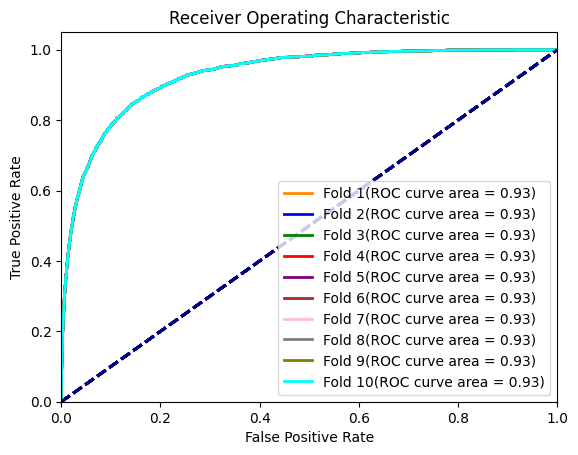

In [16]:
# 绘制ROC曲线
colors = ['darkorange', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10']
plt.figure()
for i in range(10):
    fpr, tpr, thresholds = roc_curve(true_folder['folder1_binary'],pred_folder['folder1_binary'])
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=labels[i] + '(ROC curve area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("./result/图/figre4_roc.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()

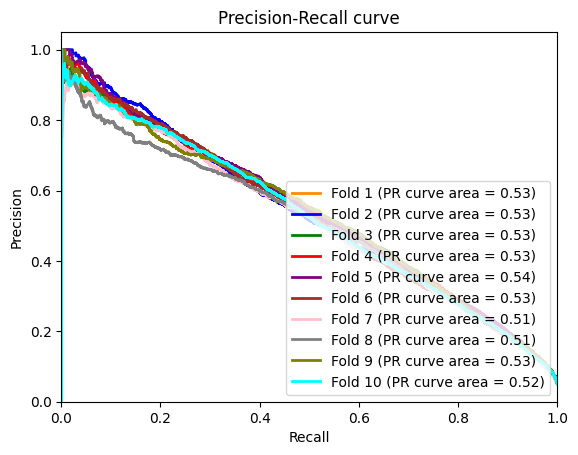

In [17]:
# 绘制ROC曲线
colors = ['darkorange', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10']
plt.figure()
for i in range(10):
    # 修改为适合你的数据结构的代码，例如 true_folder['folder1_binary'] 之类的
    precision, recall, _ = precision_recall_curve(true_folder[f'folder{i+1}_binary'], pred_folder[f'folder{i+1}_binary'])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color=colors[i], lw=2, label=labels[i] + ' (PR curve area = %0.2f)' % pr_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.savefig("./result/图/figure4_prc.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()